# <a id='title'>Оглавление</a>

### [Часть 1. Импорт библиотек / Реализация функций](#import_libs)

###  [Часть 2. Провека и подготовка датасета](#data_prep)
   > [2.1. Импорт данных](#data_prep1)  
   > [2.2. Подготовка данных](#data_prep2)   
   > [2.3. Визуализация данных](#data_prep3)  
   > [2.4. Обработка данных](#data_prep4)  

###  [Часть 3. Обучение модели](#model_train)
   > [3.1. Подбор модели](#model_train1)  
   > [3.2. Подбор гиперпараметров модели](#model_train2)  

###  [Часть 4. Рассчёт метрик](#model_eval)
   > [4.1. Выбор метрик](#model_eval1)  

## Анализ задания соренования

    Задача: Построить рекомендательную систему релевантных треков для пользователей и оценить её качество.
    
    Набор данных: Наборы данных представлены в соревновании Kaggle -
    https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/overview

    Оценка: В качестве метрики качества использовать NDCG_20.

### О данных (описание взято с страницы соревнования):

    В этом задании вам будет предложено предсказать вероятность того, что пользователь будет слушать песню повторно после первого наблюдаемого события прослушивания в определенное время. Если повторные события прослушивания происходят в течение месяца после первого наблюдаемого события прослушивания пользователем, целевая метка устанавливается на 1, иначе - на 0 в обучающем наборе данных. То же правило применяется и к тестовому набору данных.

    KKBOX предоставляет обучающий набор данных, состоящий из информации о первом наблюдаемом событии прослушивания для каждой уникальной пары пользователь-песня в определенном временном промежутке. Для каждой уникальной пары пользователь-песня также предоставляются метаданные. Использование общедоступных данных для повышения точности вашего прогноза приветствуется.

    Обучающий и тестовый наборы данных выбираются из истории прослушивания пользователей за определенный период времени. Обратите внимание, что этот период времени выбран до периода прогнозирования оттока пользователей WSDM-KKBox. Наборы данных для обучения и тестирования разделены на основе времени, а разделение на общедоступные и частные данные основано на уникальных парах пользователь-песня.

##### Таблицы имеют следующую структуру:

train.csv

- msno: идентификатор пользователя
- song_id: идентификатор песни
- source_system_tab: название вкладки, где было запущено событие. Системные вкладки используются для категоризации функций мобильных приложений KKBOX. Например, вкладка "моя библиотека" содержит функции для управления локальным хранилищем, а вкладка "поиск" содержит функции, связанные с поиском.
- source_screen_name: название макета, который видит пользователь.
- source_type: точка входа, с которой пользователь впервые воспроизводит музыку в мобильных приложениях. Точкой входа может быть альбом, онлайн-плейлист, песня и т. д.
- target: это целевая переменная. target=1 означает, что есть повторные события прослушивания, запущенные в течение месяца после очень первого наблюдаемого события прослушивания пользователем, target=0 в противном случае.


test.csv

- id: идентификатор строки (будет использоваться для отправки)
- msno: идентификатор пользователя
- song_id: идентификатор песни
- source_system_tab: название вкладки, где было запущено событие. Системные вкладки используются для категоризации функций мобильных приложений KKBOX. Например, вкладка "моя библиотека" содержит функции для управления локальным хранилищем, а вкладка "поиск" содержит функции, связанные с поиском.
- source_screen_name: название макета, который видит пользователь.
- source_type: точка входа, с которой пользователь впервые воспроизводит музыку в мобильных приложениях. Точкой входа может быть альбом, онлайн-плейлист, песня и т. д.


songs.csv
Песни. Обратите внимание, что данные представлены в кодировке Unicode.

- song_id
- song_length: в миллисекундах
- genre_ids: категория жанра. Некоторые песни имеют несколько жанров, и они разделяются символом |
- artist_name
- composer
- lyricist
- language

members.csv
информация о пользователе.

- msno
- city
- bd: возраст. Примечание: в этом столбце есть значения-выбросы, пожалуйста, используйте свое суждение.
- gender
- registered_via: метод регистрации
- registration_init_time: формат %Y%m%d
- expiration_date: формат %Y%m%d

song_extra_info.csv

- song_id
- song name - название песни.
- isrc - Международный стандартный код записи, в теории может использоваться в качестве идентификатора песни. Однако стоит отметить, что ISRC, сгенерированные от поставщиков, официально не проверены; поэтому информация в ISRC, такая как код страны и год ссылки, может быть вводящей в заблуждение/неверной. Несколько песен могут иметь один и тот же ISRC, так как одна запись может быть переиздана несколько раз.

Теперь, после получения информации о доступных нам таблиц приступим к созданию рекомендательной системы

## <a id='import_libs'>Часть 1. Импорт библиотек / Реализация функций</a>
[Оглавление](#title)

In [176]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ndcg_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from surprise import BaselineOnly, Dataset, KNNBasic, Reader, SVD, SVDpp
from surprise.model_selection import train_test_split

In [119]:
def summary(df):
    """ Функция визуализации информации о данных
    args:
        df - DataFrame    
    """
    
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df) * 100
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum = sum.sort_values(by=['missing#'], ascending=False)
    return sum

In [120]:
def group_by_age(age):
    """ Функция для создания возрастных групп
    args:
        age(int) - Возраст пользователя
    """
    if type(age) == int:              # Удостоверимся, что поступившее число имеет тип int
        if 0 <= age <= 13:            # Формируем первый возрастной диапазон 
            return 'до 13 лет'
        elif 14 <= age <= 30:         # Следующий возрастной диапазон
            return '14-30 лет'
        elif 31 <= age <= 55:         # Следующий возрастной диапазон
            return '31-55 лет'
        elif 56 <= age <= 70:         # Следующий возрастной диапазон
            return '56-70 лет'
        elif age >= 71:               # Заключительный возрастной диапазон 
            return 'больше 70 лет'
        else:
            return np.nan
    else:
        return np.nan

## <a id='data_prep'>Часть 2. Провека и подготовка датасета</a>
[Оглавление](#title)

### <a id='data_prep1'>2.1. Импорт данных</a>
[Оглавление](#title)

In [121]:
# Загрузим данные, а затем посмотрим на них

train = pd.read_csv('train.csv')
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [122]:
# Читаем файл song

songs = pd.read_csv('songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [123]:
# Читаем файл members

members = pd.read_csv('members.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [124]:
# Соеденим таблицы train, songs, members в одну таблицу

train = train.merge(songs, how='left', on='song_id') 
# А так же аналогичным образом добавим следующую таблицу
train = train.merge(members, how='left', on='msno') 

### <a id='data_prep2'>2.2. Подготовка данных</a>
[Оглавление](#title)

    Раздел делится на следующие подразделы

> [2.2.1. Заполнение отсутствующих данных](#data_prep2.1)   
> [2.2.2. Создание новых фичей](#data_prep2.2)  

#### <a id='data_prep2.1'>2.2.1. Заполнение отсутствующих данных</a>
[Оглавление](#title)

In [125]:
# Посмотрим общую информация об итоговой таблице

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(2), int64(6), object(10)
memory usage: 1013.1+ MB


In [126]:
# Посмотрим на размерность датафрейма

print('В рассаматриваемом Dataframe {} строк и {} столбцов'.format(train.shape[0], train.shape[1]))

В рассаматриваемом Dataframe 7377418 строк и 18 столбцов


In [127]:
# Мы видим, что в нашем датафрейме 7 377 418 строк 
# Удостоверимся, что пропущенных данных - нет

summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
lyricist,object,3178812,43.088408,33887,4198606
gender,object,2961479,40.142486,2,4415939
composer,object,1675706,22.713990,76064,5701712
source_screen_name,object,414804,5.622618,20,6962614
genre_ids,object,118455,1.605643,572,7258963
source_system_tab,object,24849,0.336825,8,7352569
source_type,object,21539,0.291959,12,7355879
language,float64,150,0.002033,10,7377268
song_length,float64,114,0.001545,60266,7377304
artist_name,object,114,0.001545,40582,7377304


К сожалению, мы видим что у нас присутствуют строки, с пустыми значениями, давайте подумаем как их можно заполнить, проще будет  удалить эти строчки....

Разобьём колонки на *"Категориальные"* и *"Числовые"*

Существует множество способов заполнения отсутствующих значений, но мы поступим следующим образом:

In [128]:
# Для категориальных переменных отсутствующие значения заполним значением - "Unknown"
for col in train.select_dtypes(include=['object']).columns:
    print('Обратываем колонку: {}'.format(col))
    train[col] = train[col].fillna('Unknown')

# Приступим к обработке числовых значений    

Обратываем колонку: msno
Обратываем колонку: song_id
Обратываем колонку: source_system_tab
Обратываем колонку: source_screen_name
Обратываем колонку: source_type
Обратываем колонку: genre_ids
Обратываем колонку: artist_name
Обратываем колонку: composer
Обратываем колонку: lyricist
Обратываем колонку: gender


In [129]:
# Супер посмотрим оставшиеся колонки для заполнения, обратим внимание на колоноку language

summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
language,float64,150,0.002033,10,7377268
song_length,float64,114,0.001545,60266,7377304
msno,object,0,0.000000,30755,7377418
lyricist,object,0,0.000000,33887,7377418
registration_init_time,int64,0,0.000000,3811,7377418
registered_via,int64,0,0.000000,5,7377418
gender,object,0,0.000000,3,7377418
bd,int64,0,0.000000,92,7377418
city,int64,0,0.000000,21,7377418
composer,object,0,0.000000,76064,7377418


Text(0.5, 0, 'Возможные значения для "language"')

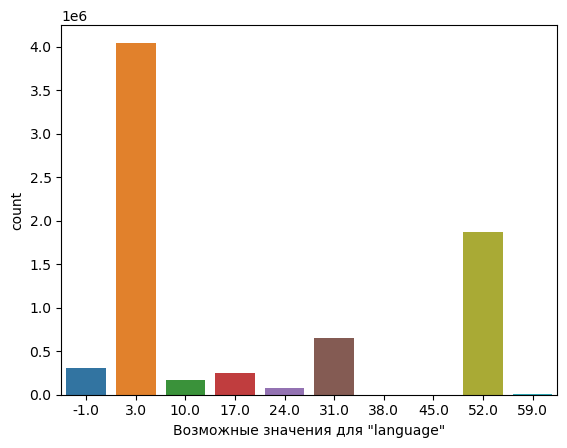

In [130]:
# Колонка language может принимать одно из 10 уникальных значений,
# с помощью countplot, посмотрим есть ли характерный класс для этой переменнойй 


sns.countplot(data=train, x='language')
plt.xlabel('Возможные значения для "language"')

In [131]:
# Мы видим, что чаще всего встречается значение 3.0, 
# скорее всего мы наткнулись на некоторую категориальную переменную,
# поэтому для заполнения значений этой колонки применим моду


# Преобразуем числовые значения в строковые
train['language'] = train['language'].astype(str)
train['language'] = train['language'].fillna(train['language'].mode())

In [132]:
# Хорошо, у нас осталась всего одна колонка, содержащая в себе отсутствующие данные
# Длина песен может быть различной заполним отсутствующие значения средней величиной

train['song_length'] = train['song_length'].fillna(train['song_length'].mean())

In [133]:
# Супер, теперь мы заполнили все отсутствующие значения

summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
msno,object,0,0.000000,30755,7377418
song_id,object,0,0.000000,359966,7377418
registration_init_time,int64,0,0.000000,3811,7377418
registered_via,int64,0,0.000000,5,7377418
gender,object,0,0.000000,3,7377418
bd,int64,0,0.000000,92,7377418
city,int64,0,0.000000,21,7377418
language,object,0,0.000000,11,7377418
lyricist,object,0,0.000000,33887,7377418
composer,object,0,0.000000,76064,7377418


#### <a id='data_prep2.2'>2.2.2. Создание новых фичей</a>
[Оглавление](#title) 

In [134]:
# Одними из самых очевидных новых фичей, могут быть отдельные колонки год/месяц/день 

# Изменим формат колонки на datetime, а затем выделим год, месяц, день
train['registration_init_time'] = pd.to_datetime(train['registration_init_time'], format='%Y%m%d')
train['registration_init_time_year'] = train['registration_init_time'].dt.year
train['registration_init_time_month'] = train['registration_init_time'].dt.month
train['registration_init_time_day'] = train['registration_init_time'].dt.day

# Сформируем аналогичные фичи из колокни expiration_date
train['expiration_date'] = pd.to_datetime(train['expiration_date'],  format='%Y%m%d')
train['expiration_date_year'] = train['expiration_date'].dt.year
train['expiration_date_month'] = train['expiration_date'].dt.month
train['expiration_date_day'] = train['expiration_date'].dt.day

In [135]:
# Обратим вниманеи на описание датафрейма, и посмотрим на колонку genre_ids
# 'genre_ids: категория жанра. Некоторые песни имеют несколько жанров, и они разделяются символом |'
#  Чтоб решить эту проблему разделим колонку на несколько частей


# Создадим отдельный датафрейм, в котором мы разделим имеющуюся колонку на множество колонок
# в которых может содержаться информация о жанре произведения
genres_df = train['genre_ids'].str.split('|', expand=True)

# Мы уже имеем колонки содержащие уникальные значения (label encoder), 
# поэтому для решения проблем с отсутствующиими значениями мы можем заполнить из нулевыми значениями 
# (число не встречается ни в одной колонке)
genres_df.fillna(0, inplace = True)

# Переименуем столбцы добавив префикс 'genre_'
genres_df = genres_df.rename(columns=lambda x: 'genre_{}'.format(x))

# Теперь объединим фиктивый датафрейм с исходным
train = pd.concat([train, genres_df], axis=1)

In [136]:
# Аналогичным образом обратимся к колонке 'lyricist'
train['lyricist'][train['lyricist'] != 'Unknown']

# Мы видим, что некоторые из значений этой колонки так же можно разделить на несколько частей
# Например строки 6, 7377414, 7377417

6                                             TEDDY| TAEYANG
11                                                        嚴爵
12                                                       林怡鳳
13                                                       周杰倫
14                                               Lin Yi Feng
                                 ...                        
7377400                                                  陳鎮川
7377401                                                  張震嶽
7377414    Theron Thomas| Timothy Thomas| Lukasz Gottwald...
7377415                 姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵
7377417                    Robert Andrew Hyman| Cyndy Lauper
Name: lyricist, Length: 4198588, dtype: object

In [137]:
# Создадим отдельный датафрейм, в котором мы разделим имеющуюся колонку на множество колонок
# в которых может содержаться информация о жанре произведения
lyricist_df = train['lyricist'].str.split('|', expand=True)

# Мы уже имеем колонки содержащие уникальные значения (label encoder), 
# поэтому для решения проблем с отсутствующиими значениями мы можем заполнить из нулевыми значениями 
# (число не встречается ни в одной колонке)
lyricist_df.fillna('Unknown', inplace = True)

# Переименуем столбцы добавив префикс 'genre_'
lyricist_df = lyricist_df.rename(columns=lambda x: 'lyricist_{}'.format(x))

# Теперь объединим фиктивый датафрейм с исходным
train = pd.concat([train, lyricist_df], axis=1)

In [138]:
# Так же в описании соревнования было сказано о наличиии выбросов в колонке 'bd'
# посмотрим на них

train['bd'].unique()

array([   0,   24,   26,   27,   18,   34,   20,   19,   28,   41,   32,
         36,   46,   30,   23,   67,   22,   29,   21,   31,   39,   35,
         16,   25,   38,   17,   43,   47,   33,   37,   44,   49,   50,
         40,   52,   45,   53,   64,   57,   48,   51,   59,   54,   42,
         55,    3,  111,   65,   73,   60,   58,   56,   66,   14,  131,
         74,   62,   61,   63,    7,  103, 1030,  -43,   15,  105,  107,
         68,   13,  931,   72,   11,    2,   87,  144,   95,   83,   12,
         93,    5,  112,   90,   10,   70,  -38,   82,   89,  106,  102,
         85, 1051,   78,   76], dtype=int64)

<Axes: xlabel='bd', ylabel='Count'>

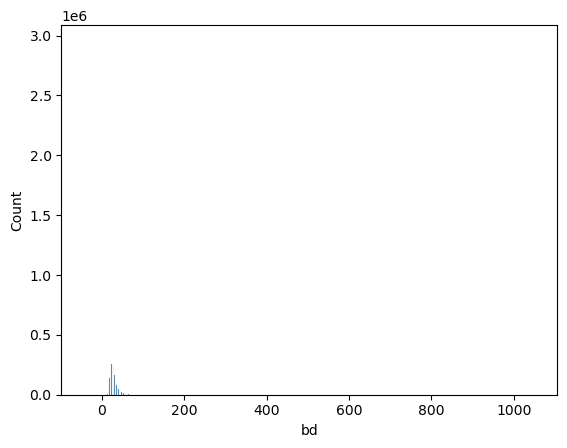

In [139]:
# Визуализируем их с помощью histplot

sns.histplot(data = train['bd'])

# # Ограничения для просмотра основных данных
# plt.xlim(1,1000)
# plt.ylim(0,10000)

In [140]:
# Действительно мы видим нестветсвенные значения. посчитаем колличество таких значений

bd_df = pd.DataFrame(train['bd'].value_counts(), columns=['count'])
bd_df = bd_df.reset_index().sort_values(by=['bd'], ascending=False)
bd_df.style.background_gradient(cmap='Blues')

,bd,count
90,1051,6
58,1030,1351
71,931,247
75,144,152
76,131,146
79,112,90
57,111,1366
78,107,94
84,106,23
59,105,1311


In [141]:
# Что мы можем сделать: 
# Для отрицательных значений мы возьмём значения по модулю, предположив что при вводе данных произошла ошибка
# Для слишном высоких значений, выбросы заменим на самое некое высокое значение, примем его равным 113

train['bd'] = train['bd'].abs()

# Ограничим максимальный возраст
max_age = 113
train['bd'] = train['bd'].clip(upper = max_age)

In [142]:
# После того как мы поправили возраста пользователей, разделим их на группы

train['age_group'] = train['bd'].apply(group_by_age)

### <a id='data_prep3'>2.3. Визуализация данных</a>
[Оглавление](#title)

Text(0.5, 0, 'Возрастная группа')

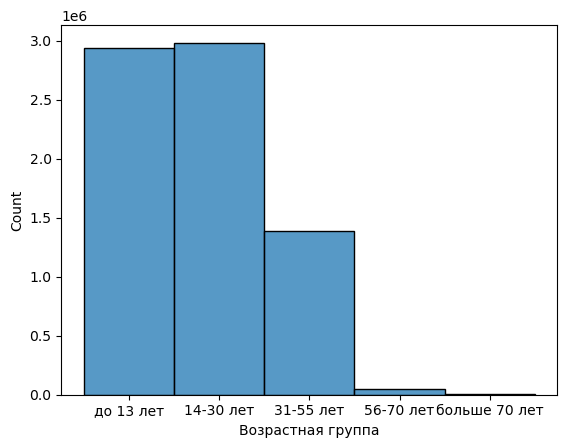

In [143]:
# Построим гистограмму для возрастных групп

sns.histplot(data = train['age_group'])
plt.xlabel('Возрастная группа')

# Мы видим, что большинство слушателей приходятся на первые две группы

<Axes: xlabel='target', ylabel='Count'>

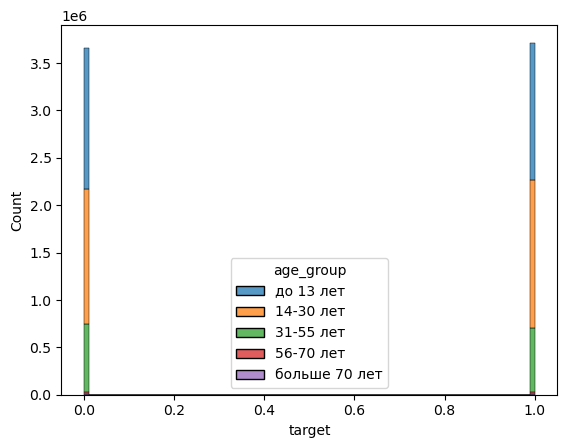

In [144]:
# Построим гистограмму для целевой переменной и отметим на грфике группы

sns.histplot(data=train, x='target', hue='age_group', multiple='stack')

# Так мы видим, что распределение целевой переменной одинаковое 

### <a id='data_prep4'>2.4. Обработка данных</a>
[Оглавление](#title)

In [145]:
# Закодируем категориальные признаки

object_columns = train.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for column in object_columns:
    train[column] = train[column].astype(str)
    train[column] = label_encoder.fit_transform(train[column])

<Axes: >

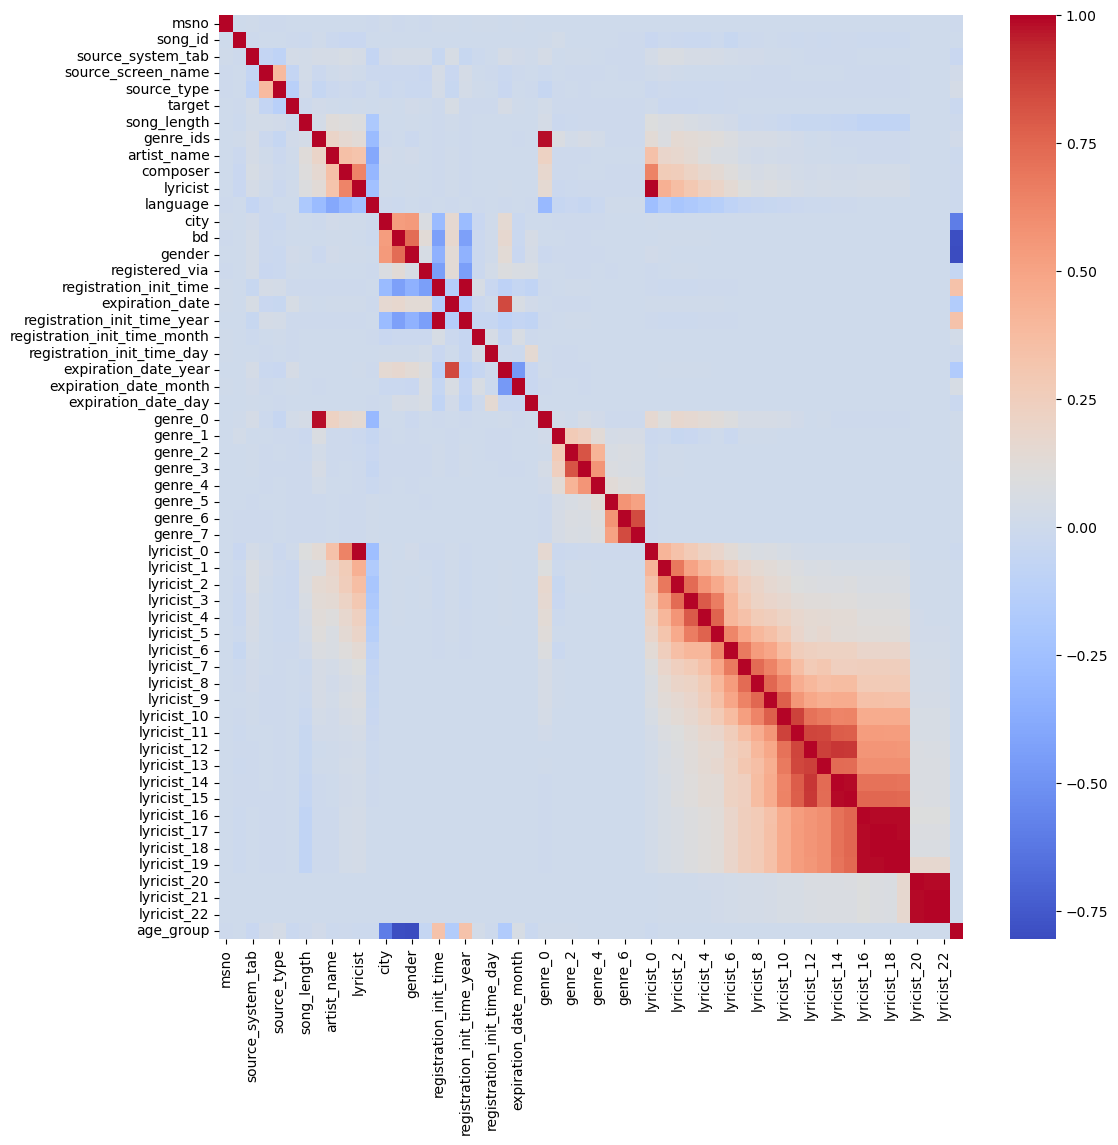

In [146]:
# Посмотрим на матрицу корреляций для нашего датафрейма

plt.figure(figsize = (12,12))
sns.heatmap(train.corr(),cmap='coolwarm')

## <a id='model_train'>Часть 3. Обучение модели</a>
[Оглавление](#title)

#### <a id='model_train1'>3.1. Подбор модели</a>
[Оглавление](#title)

    Используем бибилиотеку Surprise - библиотека предназначена для построения молоей рекомендаций.
    Для решения поставленной задачи, сделаем следующие шаги
    1) Разделим обучающие данные на train и test
    2) Пронормируем данные с помощиью MinMaxScaler
    3) Обучим базовые модели:
        - SVD
        - SVD++
        - KNN
        - BaselineOnly

In [175]:
# Получим список числовых столбцов, кроме целевой переменной
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns.difference(['target'])

# Нормализуем числовые данные
scaler = MinMaxScaler()
train_normalized = train.copy()
train_normalized[numeric_columns] = scaler.fit_transform(train_normalized[numeric_columns])


# Загрузим данные в модель Surprise
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(train[['msno', 'song_id', 'target']], reader)

# Разделим данные на обучающую и тестовую выборки
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Инициализаруем модели
models = {
    "SVD": SVD(),
    "SVD++": SVDpp(),
    "KNNBasic": KNNBasic(),
    "BaselineOnly": BaselineOnly()
}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    model.fit(trainset)

# Получим прогнозы на тестовой выборке и вычисленим метрики
ndcg_scores = {}
rmse_scores = {}

for model_name, model in models.items():
    predictions = model.test(testset)
    predicted_ratings = np.array([pred.est for pred in predictions])
    true_ratings = np.array([pred.r_ui for pred in predictions])
    
    # Преобразуем фактические значения в бинарные метки
    true_labels = np.array([1 if r > 0 else 0 for r in true_ratings])
    
    # Вычислим NDCG@20
    ndcg_scores[model_name] = ndcg_score([true_labels], [predicted_ratings], k=20)
    
    # Вычислим RMSE
    rmse_scores[model_name] = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

# Вывод результатов
for model_name, ndcg_score in ndcg_scores.items():
    print(f"NDCG@20 for {model_name}: {ndcg_score}")

for model_name, rmse_score in rmse_scores.items():
    print(f"RMSE for {model_name}: {rmse_score}")

Training SVD model...
Training SVD++ model...
Training KNNBasic model...
Computing the msd similarity matrix...
Done computing similarity matrix.
Training BaselineOnly model...
Estimating biases using als...
NDCG@20 for SVD: 0.9496108152396557
NDCG@20 for SVD++: 0.9539498315237738
NDCG@20 for KNNBasic: 0.4657599133847611
NDCG@20 for BaselineOnly: 0.9358382224441392
RMSE for SVD: 0.4558527407191876
RMSE for SVD++: 0.45733352916489545
RMSE for KNNBasic: 0.4661894919269128
RMSE for BaselineOnly: 0.4568694966918364


In [178]:
# Таким образом получившиеся модели имеют следующий результат
for model_name, ndcg_score in ndcg_scores.items():
    print(f"Метрика NDCG_20 для модели {model_name}: {ndcg_score}")

print()
    
for model_name, rmse_score in rmse_scores.items():
    print(f"Метрика RMSE для модели {model_name}: {rmse_score}")

Метрика NDCG_20 для модели SVD: 0.9496108152396557
Метрика NDCG_20 для модели SVD++: 0.9539498315237738
Метрика NDCG_20 для модели KNNBasic: 0.4657599133847611
Метрика NDCG_20 для модели BaselineOnly: 0.9358382224441392

Метрика RMSE для модели SVD: 0.4558527407191876
Метрика RMSE для модели SVD++: 0.45733352916489545
Метрика RMSE для модели KNNBasic: 0.4661894919269128
Метрика RMSE для модели BaselineOnly: 0.4568694966918364


    Для улучшения качества модели можно применить подбор гиперпараметров

## <a id='model_eval'>Часть 4. Рассчёт метрик</a>
[Оглавление](#title)

#### <a id='model_eval1'>4.1. Выбор метрик</a>
[Оглавление](#title)

#### NDCG@k (Normalized Discounted Cumulative Gain):
    NDCG измеряет качество ранжирования предложений, учитывая их релевантность. Он показывает, насколько хорошо модель ранжирует релевантные элементы выше нерелевантных.
    NDCG более чувствителен к высокорелевантным элементам, что отражает важность правильного ранжирования таких элементов.
#### RMSE (Root Mean Square Error):
    RMSE является стандартной метрикой для оценки точности предсказаний. Она измеряет среднеквадратичную ошибку между фактическими и предсказанными значениями.